In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
data = 'malaria'
os.listdir(data)

['test', 'train']

In [3]:
## train and test folder
train_path = data+'\\train\\'
test_path = data+'\\test\\'

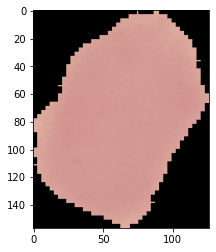

In [4]:
# Uninfected cell img
unif_cell= train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[42]
unifected_cell = imread(unif_cell)
plt.imshow(unifected_cell)

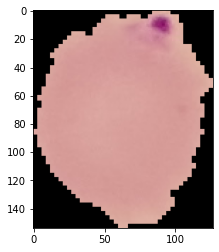

In [5]:
para_cell = train_path+'\\parasitized\\'+os.listdir(train_path+'\\parasitized')[42]
cell = imread(para_cell)
plt.imshow(cell)

In [6]:
imageDimensions= (130,130,3)

# Preparing the Data

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
#help(ImageDataGenerator)

In [9]:
image_gen = ImageDataGenerator(rotation_range = 10, # rotate the image 20 degrees
                               width_shift_range = 0.05, # Shift the pic width by a max of 5%
                               height_shift_range = 0.05, # Shift the pic height by a max of 5%
                               rescale =1/255, # Rescale the image by normalzing it.
                               shear_range = 0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range = 0.1, # Zoom in by 10% max
                               horizontal_flip= True, # Allo horizontal flipping
                               fill_mode = 'nearest' # Fill in missing pixels with the nearest filled value
                              )

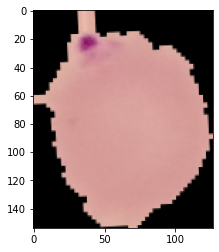

In [10]:
# lets see our preprocessing
plt.imshow(image_gen.random_transform(cell))

In [11]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [12]:
image_gen.flow_from_directory(test_path)

Found 2601 images belonging to 2 classes.


In [13]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=imageDimensions[:2],
                                                color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [14]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=imageDimensions[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

Found 2601 images belonging to 2 classes.


In [15]:
classes=train_image_gen.class_indices
classes

{'parasitized': 0, 'uninfected': 1}

# Creating the Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.optimizers import Adam

In [25]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=imageDimensions, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=imageDimensions, activation='relu',))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=imageDimensions, activation='relu',))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=imageDimensions, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))


model.add(Dropout(0.5))

# its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)            

# Training the Model

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [29]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 841s 539ms/step - loss: 0.6874 - accuracy: 0.5532 - val_loss: 0.6810 - val_accuracy: 0.5821
Epoch 2/20
1560/1560 [==============================] - 791s 507ms/step - loss: 0.6851 - accuracy: 0.5789 - val_loss: 0.6591 - val_accuracy: 0.6155
Epoch 3/20
1560/1560 [==============================] - 786s 504ms/step - loss: 0.6615 - accuracy: 0.6154 - val_loss: 0.6529 - val_accuracy: 0.6225
Epoch 4/20
1560/1560 [==============================] - 781s 501ms/step - loss: 0.3623 - accuracy: 0.8467 - val_loss: 0.1951 - val_accuracy: 0.9381
Epoch 5/20
1560/1560 [==============================] - 779s 499ms/step - loss: 0.1960 - accuracy: 0.9415 - val_loss: 0.1926 - val_accuracy: 0.9354
Epoch 6/20
1560/1560 [==============================] - 791s 507ms/step - loss: 0.1761 - accuracy: 0.9468 - val_loss: 0.1815 - val_accuracy: 0.9408
Epoch 7/20
1560/1560 [==============================] - 694s 445ms/step - loss: 0.1664 - accuracy: 0.9479 - val_

In [30]:
#evaluating the model
score = model.evaluate(test_image_gen,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.15990526974201202
Test Accuracy = 0.946943461894989


In [32]:
model.save('my_model.h5')

# Predicting the Model

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [2]:
model = load_model('my_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)            

In [5]:
### prediction function
def prediction(img):
    my_img = image.load_img(img,target_size=(130,130,3))
    my_img = image.img_to_array(my_img)
    my_img = np.expand_dims(my_img,axis=0)
    pred = model.predict_classes([my_img])[0]
    if pred == 0:
        print('Parasitized')
    elif pred == 1:
        print('Uninfected')
    ###{'parasitized': 0, 'uninfected': 1}
    return pred
    

In [3]:
img ='para_cell.png' ## Parasitized cell image

In [9]:
prediction(img)

Parasitized


array([0])

In [10]:
img2 = 'normal_cell.png' #Uninfected cell image

In [11]:
prediction(img2)

Uninfected


array([1])